<a href="https://colab.research.google.com/github/danilsab24/Semantic_Segmentation_Potsdam/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import delle librerie

In [1]:
!git clone https://github.com/danilsab24/Semantic_Segmentation_Potsdam.git

Cloning into 'Semantic_Segmentation_Potsdam'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 112 (delta 61), reused 62 (delta 24), pack-reused 0
Receiving objects: 100% (112/112), 3.60 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
from Semantic_Segmentation_Potsdam.Unet import UNET
from Semantic_Segmentation_Potsdam.dataset import MyData

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
import os

directory_path = "/content/drive/MyDrive"  # Inserisci il percorso della directory
prefix_to_remove = "top_potsdam"          # Prefisso da cercare nei nomi dei file

# Elenco dei file nella directory
file_list = os.listdir(directory_path)

# Itera attraverso i file e elimina quelli che iniziano con il prefisso specificato
for filename in file_list:
    if filename.startswith(prefix_to_remove):
        file_path = os.path.join(directory_path, filename)
        os.remove(file_path)
        print(f"File eliminato: {filename}")

print("Eliminazione completata.")
'''

'\nimport os\n\ndirectory_path = "/content/drive/MyDrive"  # Inserisci il percorso della directory\nprefix_to_remove = "top_potsdam"          # Prefisso da cercare nei nomi dei file\n\n# Elenco dei file nella directory\nfile_list = os.listdir(directory_path)\n\n# Itera attraverso i file e elimina quelli che iniziano con il prefisso specificato\nfor filename in file_list:\n    if filename.startswith(prefix_to_remove):\n        file_path = os.path.join(directory_path, filename)\n        os.remove(file_path)\n        print(f"File eliminato: {filename}")\n\nprint("Eliminazione completata.")\n'

In [4]:
# Librerie per il Dataset
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from albumentations import Compose, RandomCrop, HorizontalFlip, Normalize

# Visualizzazione delle immagini
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from PIL import Image
import os
import cv2

# Analyze Data - Exploration Data Analysis (EDA)
Dataset è composto da 38 immagini satellitari IRRG di dimensione 6000x6000 e di altre 38 immagini RGB di dimensione 6000x6000 che corrispondono alle immagini satellitari già segmentate in 6 classi:
 1. Impervious surfaces
 2. Building
 3. Low vegetation
 4. Tree
 5. Car
 6. Clutter/background

# Plot immagini dataset

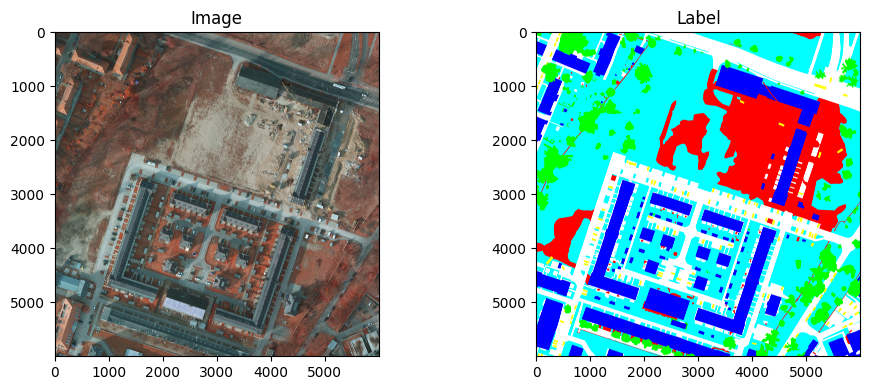

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorsi dei file delle immagini
image_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10.tif'
label_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif'

# Carica le immagini
image = mpimg.imread(image_path)
label = mpimg.imread(label_path)

# Crea una figura con un subplot 1x2
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Mostra l'immagine nella prima subplot
axs[0].imshow(image)
axs[0].set_title('Image')

# Mostra l'etichetta nella seconda subplot
axs[1].imshow(label)
axs[1].set_title('Label')

# Spaziatura tra i subplots
plt.tight_layout()

# Mostra il plot
plt.show()


# Controllo dimensioni
Controllo se tutte le immagini del dataset hanno le stesse dimensioni

In [32]:
import os
from PIL import Image

def check_dimensioni(path_1):

  image_filenames = os.listdir(path_1)

  # Verifica delle dimensioni delle immagini
  image_size_set = set()

  for image_filename in image_filenames:
      image_path = os.path.join(path_1, image_filename)

      image = Image.open(image_path)

      image_size = image.size

      image_size_set.add(image_size)

  # Controlla se tutte le immagini hanno le stesse dimensioni
  if len(image_size_set) == 1:
      common_image_size = image_size_set.pop()
      print("Tutte le immagini hanno la stessa dimensione:")
      print("Dimensione immagini:", common_image_size)
  else:
      print("Le immagini non hanno tutte la stessa dimensione.")

image_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG'
label_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels'

check_dimensioni(image_folder)
check_dimensioni(label_folder)

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)
Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)


# Suddivisione in Patch
Poichè le immagini del dataset sono troppo grandi le suddivido in patch di dimensione 250x250

In [8]:
from PIL import Image
import os

# Percorso delle immagini originali e destinazione delle patch
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
patch_images_save_path = "/content/"
patch_folder_name = "images_patches"

# Dimensioni delle patch desiderate
patch_size = 250  # Dimensione delle patch, puoi regolarla in base alle tue esigenze

# Crea la cartella per le patch se non esiste
patch_folder_path = os.path.join(patch_images_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)

# Ciclo attraverso le immagini originali
for image_filename in os.listdir(original_images_path):
  if image_filename.endswith(".tif"):
      image_path = os.path.join(original_images_path, image_filename)

      # Carica l'immagine
      image = Image.open(image_path)

      # Estrai le patch dall'immagine
      num_patches = (image.width // patch_size) * (image.height // patch_size)
      for i in range(0, image.width, patch_size):
          for j in range(0, image.height, patch_size):
              patch = image.crop((i, j, i + patch_size, j + patch_size))
              patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"   # Genera un nome univoco per ogni patch
              patch_save_location = os.path.join(patch_folder_path, patch_filename)

              # Controlla se la patch esiste già
              if not os.path.exists(patch_save_location):
                  patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")


Riduzione delle immagini in patch completata.


In [9]:
# Percorso delle immagini originali e destinazione delle patch
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"
patch_Labels_save_path = "/content/"
patch_folder_name = "labels_patches"

# Dimensioni delle patch desiderate
patch_size = 250  # Dimensione delle patch, puoi regolarla in base alle tue esigenze

# Crea la cartella per le patch se non esiste
patch_folder_path = os.path.join(patch_Labels_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)


# Ciclo attraverso le immagini originali
for image_filename in os.listdir(original_images_path):
    if image_filename.endswith(".tif"):
        image_path = os.path.join(original_images_path, image_filename)

        # Carica l'immagine
        image = Image.open(image_path)

        # Estrai le patch dall'immagine
        num_patches = (image.width // patch_size) * (image.height // patch_size)
        for i in range(0, image.width, patch_size):
            for j in range(0, image.height, patch_size):
                patch = image.crop((i, j, i + patch_size, j + patch_size))
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"   # Genera un nome univoco per ogni patch
                patch_save_location = os.path.join(patch_folder_path, patch_filename)

                # Controlla se la patch esiste già
                if not os.path.exists(patch_save_location):
                    patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")

Riduzione delle immagini in patch completata.


# Controllo numero immagini
Essendoci nel dataset originale 38 immagini IRRG di dimensione 6000x6000 e 38 immagini RGB di dimensione 6000x6000, nelle cartelle che contendo le patch ci drovanno essere in ogni cartella: \
$ [(6000\cdot6000)/(250\cdot250)]\cdot38 = 21888 $

In [10]:
def check_num_element(path):
  # Contatore per le immagini
  image_count = 0

  # Ciclo attraverso i file nella cartella delle patch
  for filename in os.listdir(path):
      if filename.endswith(".tif"):
          image_count += 1
  return image_count

patch_folder_path_images = "/content/images_patches"
num = check_num_element(patch_folder_path_images)
print(f"Numero totale di immagini nella cartella images_patches: {num}")

patch_folder_path_label = "/content/labels_patches"
num = check_num_element(patch_folder_path_images)
print(f"Numero totale di immagini nella cartella labels_patches: {num}")

Numero totale di immagini nella cartella images_patches: 21888
Numero totale di immagini nella cartella labels_patches: 21888


# Controllo dimensioni delle patch

In [26]:
import os
from PIL import Image

image_folder = '/content/images_patches'
label_folder = '/content/labels_patches'

image_filenames = os.listdir(image_folder)
label_filenames = os.listdir(label_folder)

# Verifica delle dimensioni delle immagini
image_size_set = set()
label_size_set = set()

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image_path = os.path.join(image_folder, image_filename)
    label_path = os.path.join(label_folder, label_filename)

    image = Image.open(image_path)
    label = Image.open(label_path)

    image_size = image.size
    label_size = label.size

    image_size_set.add(image_size)
    label_size_set.add(label_size)

# Controlla se tutte le immagini hanno le stesse dimensioni
if len(image_size_set) == 1 and len(label_size_set) == 1:
    common_image_size = image_size_set.pop()
    common_label_size = label_size_set.pop()
    print("Tutte le immagini hanno la stessa dimensione:")
    print("Dimensione immagini:", common_image_size)
    print("Dimensione etichette:", common_label_size)
else:
    print("Le immagini non hanno tutte la stessa dimensione.")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)
Dimensione etichette: (250, 250)


In [ ]:
'''
import os

# Percorso della cartella contenente le immagini
images_folder_path = "/content/labels_patch_converted"

# Ciclo attraverso i file nella cartella
for filename in os.listdir(images_folder_path):
    if filename.startswith("top_potsdam") and filename.endswith(".tif"):
        file_path = os.path.join(images_folder_path, filename)
        os.remove(file_path)
        print(f"File eliminato: {filename}")

print("Eliminazione completata.")
'''

# Plot delle patch

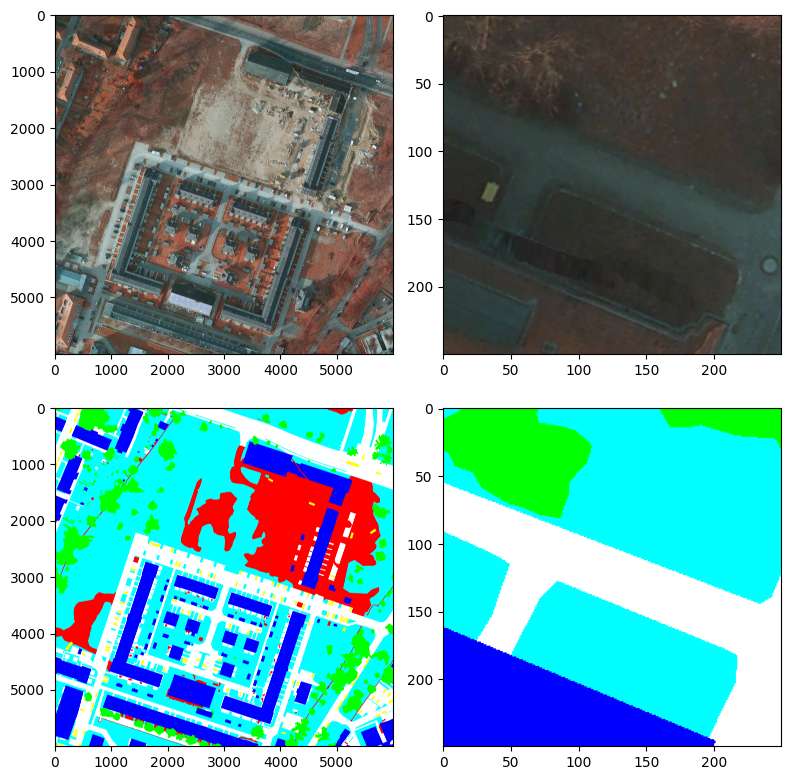

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorsi delle immagini
image_paths = [
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10.tif",
    "/content/images_patches/top_potsdam_2_10_patch_0_0.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif",
    "/content/labels_patches/top_potsdam_2_10_patch_0_0.tif"
]

# Creazione della griglia delle immagini
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('on')

plt.tight_layout()
plt.show()


# Mapping delle label
Le immagini segmentate sono in formato RGB ma ad ogni colore corrisponde una classe :
 *   (255, 255, 255)(Colore: Bianco)   Impervious surfaces
 *   (0, 0, 255)     (Colore: Blu)     Building
 *   (0, 255, 255)    (Colore: Ciano)  Low vegetation
 *   (0, 255, 0)      (Colore: Verde)  Tree
 *   (255, 255, 0)   (Colore: Giallo)  Car
 *   (255, 0, 0)     (Colore: Rosso)   Clutter/background

In [ ]:
from PIL import Image
import os

class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5      # Clutter/background
}

input_folder = '/content/labels_patches'
output_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted'

os.makedirs(output_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(input_folder) if filename.endswith('.tif')]
total_images = len(file_list)
converted_images = 0

print("Total images to convert:", total_images)

for filename in file_list:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    input_image = Image.open(input_path)
    output_image = Image.new('L', input_image.size)  # Create a new grayscale image

    for y in range(input_image.height):
        for x in range(input_image.width):
            pixel_value = input_image.getpixel((x, y))[:3]  # Get RGB value

            if pixel_value in class_mapping:
                output_image.putpixel((x, y), class_mapping[pixel_value])
    converted_images += 1
    print("Converted: ",converted_images)
    output_image.save(output_path)

print("\nConversione completata.")


Output streaming troncato alle ultime 5000 righe.
Converted:  16891
Converted:  16892
Converted:  16893
Converted:  16894
Converted:  16895
Converted:  16896
Converted:  16897
Converted:  16898
Converted:  16899
Converted:  16900
Converted:  16901
Converted:  16902
Converted:  16903
Converted:  16904
Converted:  16905
Converted:  16906
Converted:  16907
Converted:  16908
Converted:  16909
Converted:  16910
Converted:  16911
Converted:  16912
Converted:  16913
Converted:  16914
Converted:  16915
Converted:  16916
Converted:  16917
Converted:  16918
Converted:  16919
Converted:  16920
Converted:  16921
Converted:  16922
Converted:  16923
Converted:  16924
Converted:  16925
Converted:  16926
Converted:  16927
Converted:  16928
Converted:  16929
Converted:  16930
Converted:  16931
Converted:  16932
Converted:  16933
Converted:  16934
Converted:  16935
Converted:  16936
Converted:  16937
Converted:  16938
Converted:  16939
Converted:  16940
Converted:  16941
Converted:  16942
Converted:  16

In [10]:
from PIL import Image
import os

class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5      # Clutter/background
}

input_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels'
output_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted'

os.makedirs(output_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(input_folder) if filename.endswith('.tif')]
total_images = len(file_list)
converted_images = 0

print("Total images to convert:", total_images)

for filename in file_list:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    input_image = Image.open(input_path)
    output_image = Image.new('L', input_image.size)  # Create a new grayscale image

    for y in range(input_image.height):
        for x in range(input_image.width):
            pixel_value = input_image.getpixel((x, y))[:3]  # Get RGB value

            if pixel_value in class_mapping:
                output_image.putpixel((x, y), class_mapping[pixel_value])
    converted_images += 1
    print("Converted: ",converted_images)
    output_image.save(output_path)

print("\nConversione completata.")


Total images to convert: 38
Converted:  1
Converted:  2
Converted:  3
Converted:  4
Converted:  5
Converted:  6
Converted:  7
Converted:  8
Converted:  9
Converted:  10
Converted:  11
Converted:  12
Converted:  13
Converted:  14
Converted:  15
Converted:  16
Converted:  17
Converted:  18
Converted:  19
Converted:  20
Converted:  21
Converted:  22
Converted:  23
Converted:  24
Converted:  25
Converted:  26
Converted:  27
Converted:  28
Converted:  29
Converted:  30
Converted:  31
Converted:  32
Converted:  33
Converted:  34
Converted:  35
Converted:  36
Converted:  37
Converted:  38

Conversione completata.


In [20]:
# Percorso della cartella delle patch
patch_folder_path_label_converted = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted: {num}")

# Percorso della cartella delle patch
patch_folder_path_label_converted = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted (label originali convertite): {num}")

Numero totale di immagini nella cartella label_converted: 21888
Numero totale di immagini nella cartella label_converted (label originali convertite): 38


# Controllo dimensioni delle label convertite

In [33]:
check_dimensioni("/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted")
check_dimensioni("/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)
Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)


# Plot del mapping

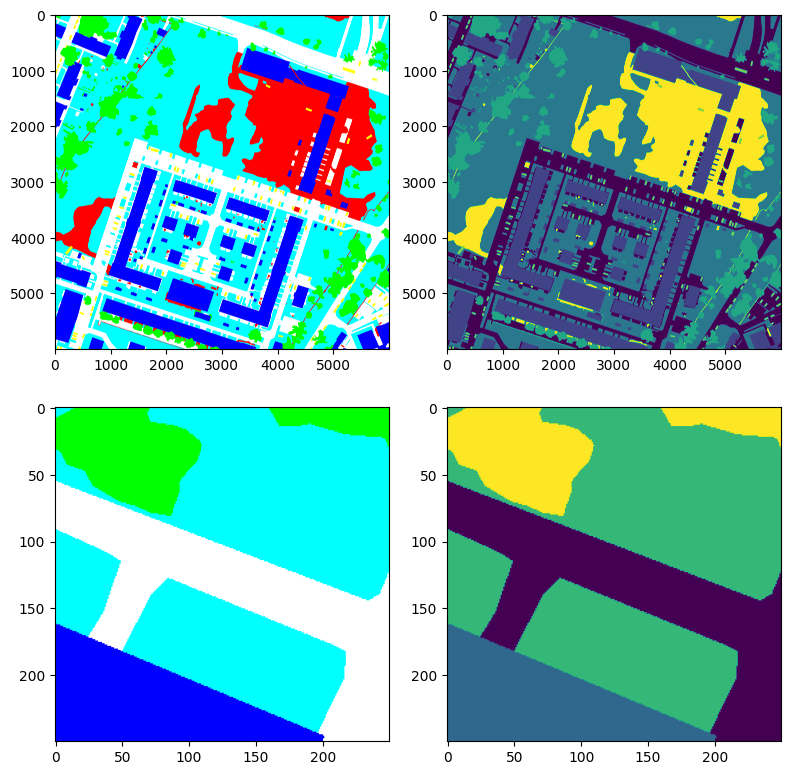

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorsi delle immagini
image_paths = [
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted/top_potsdam_2_10.tif",
    "/content/labels_patches/top_potsdam_2_10_patch_0_0.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted/top_potsdam_2_10_label_patch_0_0.tif"
]

# Creazione della griglia delle immagini
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('on')

plt.tight_layout()
plt.show()

# Copia  in colab
Copia della cartella con le patch delle label convertite da google drive su colab

In [23]:
import os
import shutil

source_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted'
destination_folder = '/content/labels_patch_converted'

os.makedirs(destination_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(source_folder) if filename.endswith('.tif')]
total_images = len(file_list)

num_copy = 0

for filename in os.listdir(source_folder):
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder, filename)

    shutil.copy(source_path, destination_path)
    num_copy += 1
    #print("Copy Image: ",num_copy," / ",total_images)

print("Copia completata.")

Copia completata.


In [24]:
# Percorso della cartella delle patch
patch_folder_path_label_converted = "/content/labels_patch_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted (posizione Colab): {num}")

Numero totale di immagini nella cartella label_converted (posizione Colab): 21888


In [34]:
check_dimensioni("/content/labels_patch_converted")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)


# Rinominazione delle immagini
Per fare in modo che ci sia una corrispondenza tra immagine non segmentate e label rinomino tutte le immagini

In [25]:
import os

def rename_files_in_folder(folder_path, old_substring, new_substring):
    for filename in os.listdir(folder_path):
        if old_substring in filename:
            new_filename = filename.replace(old_substring, new_substring)
            old_file_path = os.path.join(folder_path, filename)
            new_file_path = os.path.join(folder_path, new_filename)
            os.rename(old_file_path, new_file_path)
            #print(f"File rinominato: {filename} -> {new_filename}")

# Cartella delle immagini non segmentate
data_folder = "/content/images_patches"
rename_files_in_folder(data_folder, "_IRRG", "")

# Cartella delle immagini segmentate
target_folder = "/content/labels_patches"
rename_files_in_folder(target_folder, "_label", "")

# Cartella delle immagini segmentate
target_folder = "/content/labels_patch_converted"
rename_files_in_folder(target_folder, "_label", "")

# Cartella delle immagini non segmentate
data_folder = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
rename_files_in_folder(data_folder, "_IRRG", "")

# Cartella delle immagini segmentate
target_folder = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"
rename_files_in_folder(target_folder, "_label", "")

print("Rinominazione completata.")

Rinominazione completata.


# Creazione Train set, Validation set e Test set

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])
train_transform = Compose([
    HorizontalFlip(p=0.5),  # Esempio di data augmentation: flip orizzontale
    transforms.RandomResizedCrop(224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
    transforms.ToTensor()
])

# Trasformazione per il test (solo normalizzazione)
test_transform = transforms.Compose([
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
    transforms.ToTensor()
])

In [4]:
patch_Images_save_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
patch_Labels_save_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted"
# Creazione del dataset
dataset = MyData(patch_Images_save_path, patch_Labels_save_path, transform=transforms.ToTensor())

# Divisione dei dati in train, validation e test set
val_split = 0.1
test_split = 0.1
dataset_size = len(dataset)
val_size = int(val_split * dataset_size)
test_size = int(test_split * dataset_size)
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Applica le trasformazioni al trainset e al testset
train_dataset.transform = train_transform
val_dataset.transform = test_transform
test_dataset.transform = test_transform

# Creazione dei DataLoader
batch_size = 1  # Definisci la dimensione del batch desiderata

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
# Stampa delle dimensioni dei dataset
print(f"Dataset size: {len(dataset)} samples")
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

Dataset size: 38 samples
Train dataset size: 32 samples
Validation dataset size: 3 samples
Test dataset size: 3 samples


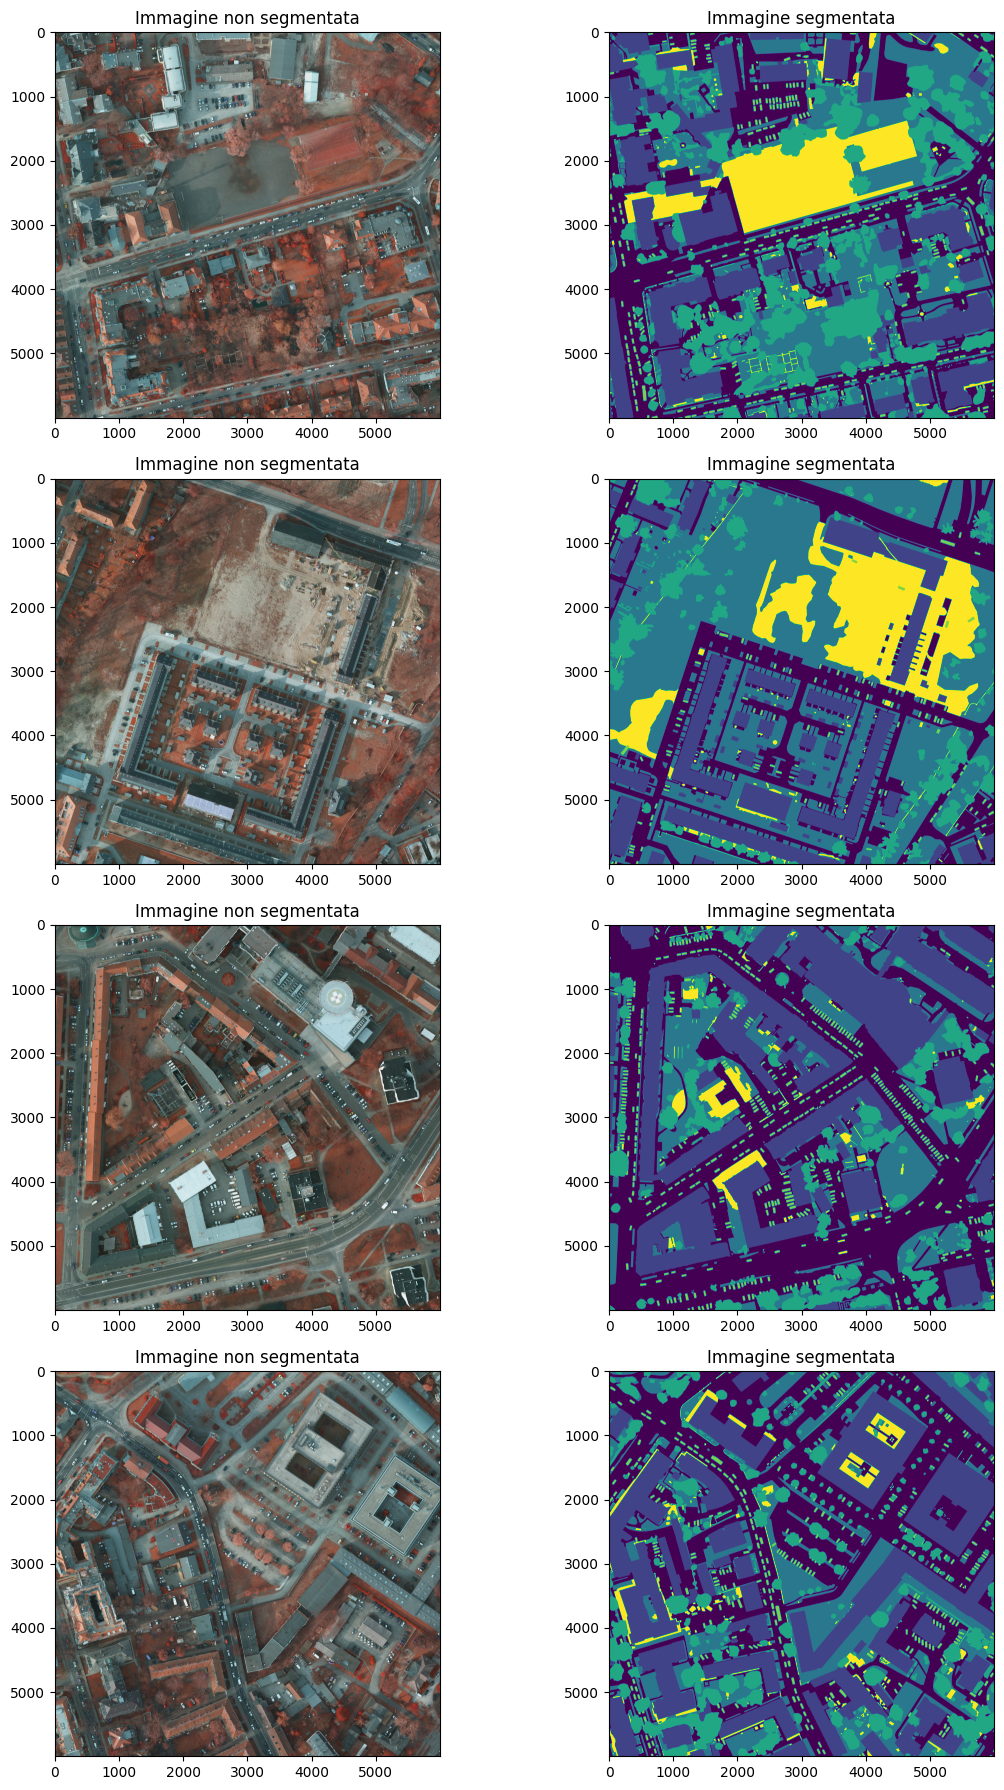

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Ottieni un batch dal train_loader
dataiter = iter(train_loader)
data_batch, target_batch = next(dataiter)

# Prendi le prime 4 immagini dal batch
data_batch = data_batch[:4]
target_batch = target_batch[:4]

# Visualizza le immagini
fig, axes = plt.subplots(4, 2, figsize=(12, 18))

for i in range(4):
    data_img = np.transpose(data_batch[i].numpy(), (1, 2, 0))
    target_img = np.transpose(target_batch[i].numpy(), (1, 2, 0))

    axes[i, 0].imshow(data_img)
    axes[i, 0].set_title("Immagine non segmentata")
    axes[i, 0].axis('on')

    axes[i, 1].imshow(target_img)
    axes[i, 1].set_title("Immagine segmentata")
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

In [5]:
# Progress bar
from tqdm.notebook import tqdm

import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [6]:
model = UNET(3, 6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# definizione della funzione di perdita, CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stri

In [7]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
      # Copy data to GPU if needed
      data = data.to(device)
      #print(target)
      #data = data.double()
      target = target.squeeze(1).to(device)
      #print(target)
      #print("shape data: ",np.shape(data))
      #print("shape target: ",np.shape(target))

      # Pass data through the network
      output = model(data)
      #print("shape output before Softmax: ",np.shape(output))

      # Apply Softmax to the output to convert them to probabilities
      LogSoftmax = nn.LogSoftmax(dim=1)
      output = LogSoftmax(output)
      #print("shape output after Softmax: ",np.shape(output))

      # Calculate loss
      loss = criterion(output, target.long())

      # Zero gradient buffers
      optimizer.zero_grad()

      # Backpropagate
      loss.backward()

      # Update weights
      optimizer.step()

      running_loss += loss.item()

      if batch_idx % log_interval == 0:
          # Log the running loss
          #writer.add_scalar('training loss', running_loss / log_interval,                                   #consente di avere nel TensorBoard un grafico della TrainingLoss
                              #epoch * len(train_loader) + batch_idx)
          running_loss = 0.0

          # Generate predictions vs. actuals figure
          inputs, labels = data.cpu(), target.cpu()
          #writer.add_figure('predictions vs. actuals', plot_classes_preds(model, inputs, labels),           # consente di avere nel TensorBorda una serie di immagini
                            #global_step=epoch * len(train_loader) + batch_idx)                              # che indicano come vengono predette le classi
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
import torch.nn as nn
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            print("shape y: ",np.shape(y))
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            print("shape preds: ",np.shape(preds))
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [8]:
import torch.nn as nn
def validate(loss_vector, accuracy_vector):
    num_correct = 0
    num_pixels = 0
    model.eval()
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():  # Aggiunta di torch.no_grad() per evitare il calcolo dei gradienti durante la validazione
            output = model(data)
            #print(np.shape(output))

            softmax = nn.LogSoftmax(dim=1)
            pred = torch.argmax(softmax(model(data)))
            print(np.shape(target))

            num_correct += (pred == target).sum()

            num_pixels += torch.numel(pred)
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")

In [ ]:
def validate(loss_vector, accuracy_vector):
    model.eval()                                               # è come se impostassimo il modello in modalità "valutazione"
    val_loss, correct = 0, 0
    num_pixels = 0                                  # ovvero ad esempio disabilita tecniche di regolarizzazione per
    for data, target in val_loader:                            # per non influenzare i dati
        #print("data: ",data)
        #print("target: ",target)
        data = data.to(device)
        target = target.squeeze(1).to(device)
        #print("target: ",target)
        #print("shape of target",np.shape(target))
        #print("target: ",target)

        with torch.no_grad():
          output = model(data)
          #print("shape of output",np.shape(output))

          LogSoftmax = nn.LogSoftmax(dim=1)
          output = LogSoftmax(output)
          #print("output: ",output)

          pred = torch.argmax(output, axis=1)
          #print("pred: ",pred)
          loss = criterion(output, target.long())
          val_loss += loss.item()

          #correct += pred.eq(target.view_as(pred)).sum().item()
          correct += (pred == target).sum()
          num_pixels += torch.numel(pred)

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / num_pixels


    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, num_pixels, accuracy))

In [ ]:
class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5      # Clutter/background
}
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    class_mapping_reverse = {v: k for k, v in class_mapping.items()}

    for data, target in val_loader:
        print("shape of data",np.shape(data))
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)

        val_loss += loss.item()
        print("shape of output",np.shape(output))
        print("shape of target",np.shape(target))
        # Convert model output to class predictions
        predictions = output.argmax(dim=1)  # Get the class index with the highest probability
        print("shape of predictions",np.shape(predictions))

        # Map predicted class indices to RGB values
        predictions_rgb = torch.zeros_like(data, dtype=torch.float32, device=device)
        for class_idx, rgb_value in class_mapping_reverse.items():
            mask = predictions == class_idx
            rgb_tensor = torch.tensor(rgb_value, dtype=torch.float32, device=device)
            for channel in range(3):
                predictions_rgb[:, channel][mask] = rgb_tensor[channel]

        # Calculate accuracy
        print("shape of predictions_rgb",np.shape(predictions_rgb))
        correct += (predictions_rgb == target.float()).all(dim=1).all(dim=1).all(dim=1).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / (len(val_loader.dataset) * data.shape[2] * data.shape[3])

    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
        val_loss, accuracy))

In [ ]:
from PIL import Image

def check_image_type(image_path):
    try:
        image = Image.open(image_path)
        if image.mode == 'RGB':
            return "RGB"
        elif image.mode == 'L':
            return "Grayscale"
        else:
            return "Unknown"
    except Exception as e:
        return "Error"

image_path = "/content/labels_patches/top_potsdam_2_10_patch_0_0.tif"
image_type = check_image_type(image_path)

if image_type == "RGB":
    print("L'immagine è in formato RGB.")
elif image_type == "Grayscale":
    print("L'immagine è in scala di grigi.")
elif image_type == "Error":
    print("Si è verificato un errore durante l'apertura dell'immagine.")
else:
    print("Non è stato possibile determinare il tipo di immagine.")

L'immagine è in formato RGB.


In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.squeeze(1).type(torch.LongTensor).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            print("y: ",y)
            y = y.squeeze(1).type(torch.LongTensor).to(device)
            output = model(x)
            #print("shape of output",np.shape(output))

            softmax = nn.Softmax(dim=1)
            output = softmax(output)
            preds = torch.argmax(output, axis=1)
            print("ypreds: ",preds)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")

In [9]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    #train_fn(train_loader,model,optimizer,criterion,scaler)
    validate(lossv, accv)
    #check_accuracy(val_loader,model)

OutOfMemoryError: ignored

In [ ]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes_name = ["Impervious surfaces",
              "Building",
              "Low vegetation",
              "Tree",
              "Car",
              "Clutter/background"]
class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5      # Clutter/background
}

def test():
    model.eval()
    correct = 0
    num_pixels = 0
    predicted_labels = []
    true_labels = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)
        #print("output: ",output)

        pred = torch.argmax(output, axis=1)
        #correct += pred.eq(target.view_as(pred)).sum().item()
        correct += (pred == target).sum()
        num_pixels += torch.numel(pred)

        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

    accuracy = 100.0 * correct / num_pixels
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, num_pixels, accuracy))

    return predicted_labels, true_labels

predicted_labels, true_labels = test()

predicted_labels = np.array(predicted_labels).flatten()
true_labels = np.array(true_labels).flatten()

# calolo della confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print del classification report
print("Classification report for MLP:\n%s\n"
      % (classification_report(true_labels, predicted_labels, target_names=classes_name)))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Accuracy: 112617597/136750000 (82.35%)

Classification report for MLP:
                     precision    recall  f1-score   support

Impervious surfaces       0.83      0.88      0.85  43367269
           Building       0.93      0.85      0.89  33237555
     Low vegetation       0.76      0.85      0.80  30888824
               Tree       0.84      0.75      0.79  20910363
                Car       0.83      0.85      0.84   2354690
 Clutter/background       0.49      0.40      0.44   5991299

           accuracy                           0.82 136750000
          macro avg       0.78      0.76      0.77 136750000
       weighted avg       0.82      0.82      0.82 136750000




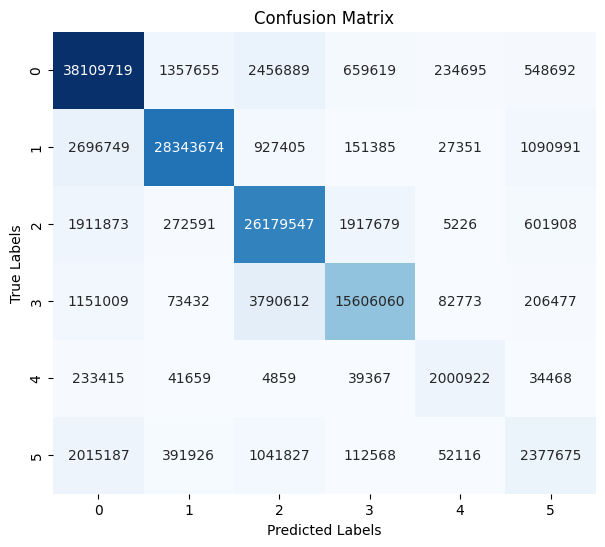

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

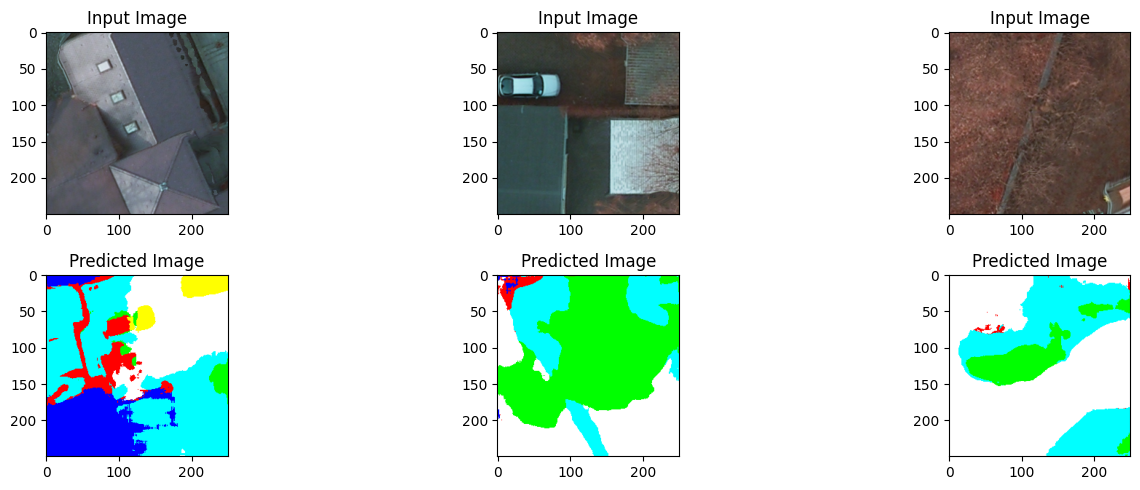

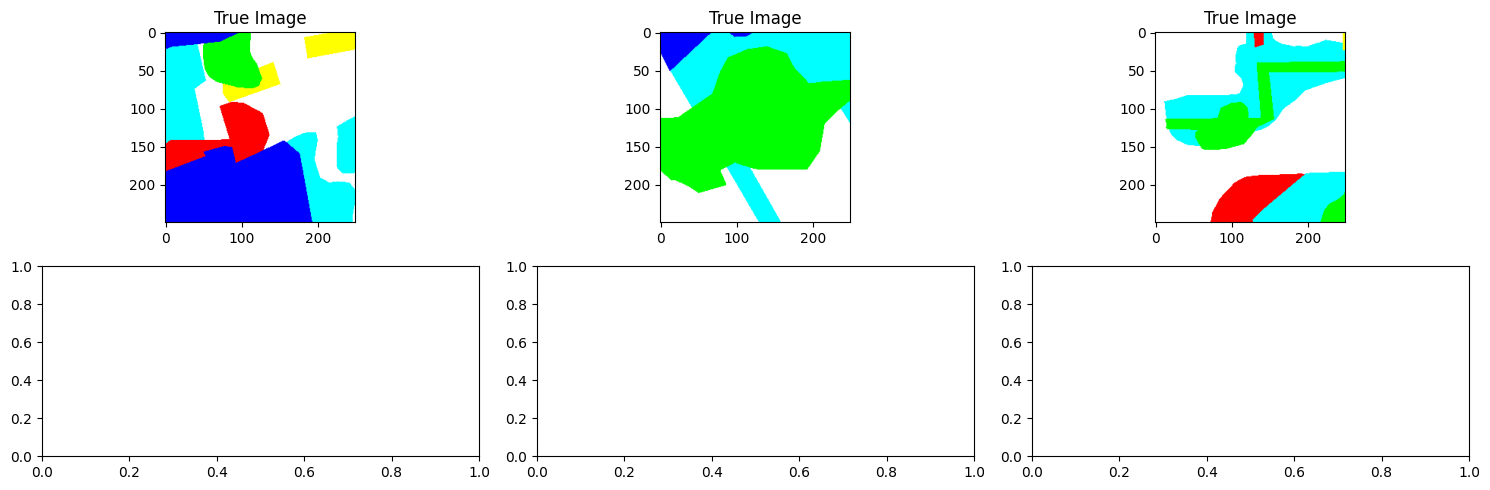

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms

# Definizione della funzione visualize_labels
def visualize_labels(label_ids):
    class_mapping = {
        0: (255, 255, 255),  # Impervious surfaces
        1: (0, 0, 255),      # Building
        2: (0, 255, 255),    # Low vegetation
        3: (0, 255, 0),      # Tree
        4: (255, 255, 0),    # Car
        5: (255, 0, 0)       # Clutter/background
    }

    color_images = []
    for label_id in label_ids:
        color_image = torch.zeros((3, 250, 250), dtype=torch.uint8)
        for class_id, color in class_mapping.items():
            mask = label_id == class_id
            color_image[0][mask] = color[0]
            color_image[1][mask] = color[1]
            color_image[2][mask] = color[2]
        color_images.append(color_image)

    return color_images

# Definizione della funzione test modificata
def test_and_visualize():
    model.eval()
    predicted_labels = []
    true_labels = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)

        pred = torch.argmax(output, axis=1)

        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

    predicted_color_images = visualize_labels(predicted_labels)
    true_color_images = visualize_labels(true_labels)

    # Visualizzazione delle immagini
    num_images = min(len(predicted_color_images), 3)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[0, i].imshow(transforms.ToPILImage()(data[i].cpu()))
        axes[0, i].set_title("Input Image")

        axes[1, i].imshow(predicted_color_images[i].permute(1, 2, 0))
        axes[1, i].set_title("Predicted Image")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[0, i].imshow(true_color_images[i].permute(1, 2, 0))
        axes[0, i].set_title("True Image")

    plt.tight_layout()
    plt.show()

# Chiamata della funzione test_and_visualize
test_and_visualize()


In [ ]:
class_mapping = {
    0: (255, 255, 255),  # Impervious surfaces
    1: (0, 0, 255),      # Building
    2: (0, 255, 255),    # Low vegetation
    3: (0, 255, 0),      # Tree
    4: (255, 255, 0),    # Car
    5: (255, 0, 0)       # Clutter/background
}

def save_image_with_overlay(predicted_label, filename):
    overlay = np.zeros((predicted_label.shape[0], predicted_label.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_mapping.items():
        overlay[predicted_label == class_id] = color

    pil_image = Image.fromarray(overlay)
    pil_image.save(filename)

def save_predicted_images(test_loader, model, save_path):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)

        pred = torch.argmax(output, axis=1)

        for j in range(len(pred)):
            predicted_label = pred[j].cpu().numpy()

            image_filename = os.path.join(save_path, f"predicted_{i}_{j}.tif")
            save_image_with_overlay(predicted_label, image_filename)

# Salvataggio delle immagini predette
save_path = '/content/images_pred_RGB'
os.makedirs(save_path, exist_ok=True)
save_predicted_images(test_loader, model, save_path)

In [ ]:
# Percorso della cartella delle patch
patch_folder_path = "/content/images_pred_RGB"

# Contatore per le immagini
image_count = 0

# Ciclo attraverso i file nella cartella delle patch
for filename in os.listdir(patch_folder_path):
    if filename.endswith(".tif"):
        image_count += 1

print(f"Numero totale di immagini nella cartella delle patch: {image_count}")

Numero totale di immagini nella cartella delle patch: 2188


In [ ]:
import os

output_dir = '/content/images_pred_RGB'
os.makedirs(output_dir, exist_ok=True)

from PIL import Image

for idx, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.squeeze(1).to(device)

    output = model(data)
    LogSoftmax = nn.LogSoftmax(dim=1)
    output = LogSoftmax(output)

    pred = torch.argmax(output, axis=1)

    # Convert predicted labels to RGB format
    pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
    for color, label in class_mapping.items():
        mask = pred == label
        pred_rgb[mask] = color

    # Create a blank image of size 6000x6000
    full_pred_image = np.zeros((6000, 6000, 3), dtype=np.uint8)

    # Place the patch predictions at their respective positions
    for i in range(pred.shape[0]):
        row_start = i * 250
        row_end = row_start + 250
        for j in range(pred.shape[1]):
            col_start = j * 250
            col_end = col_start + 250
            full_pred_image[row_start:row_end, col_start:col_end] = pred_rgb[i, j]

    # Save the full predicted image
    pred_image_path = os.path.join(output_dir, f'predicted_image_{idx}.tif')
    pred_pil_image = Image.fromarray(full_pred_image)
    pred_pil_image.save(pred_image_path)


In [ ]:
'''
import os

# Percorso della cartella contenente le immagini
images_folder_path = "/content/images_pred_RGB"

# Ciclo attraverso i file nella cartella
for filename in os.listdir(images_folder_path):
    if  filename.endswith(".tif"):
        file_path = os.path.join(images_folder_path, filename)
        os.remove(file_path)
        print(f"File eliminato: {filename}")

print("Eliminazione completata.")
'''

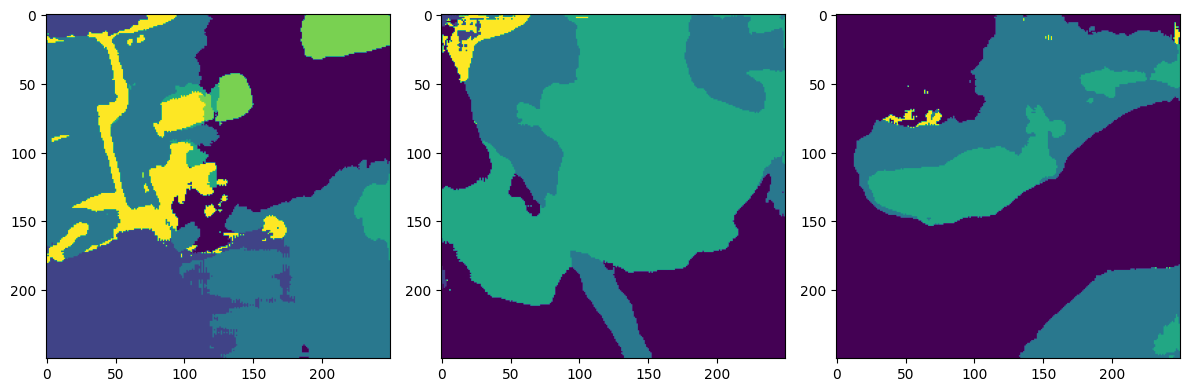

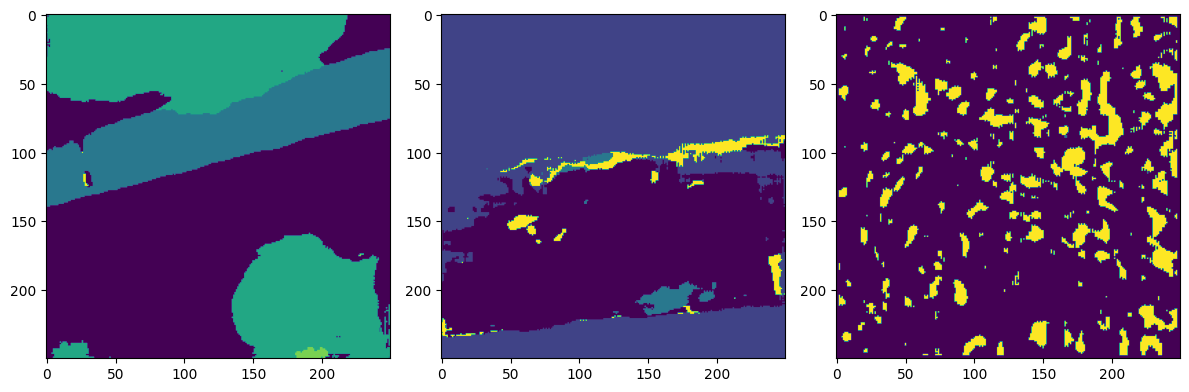

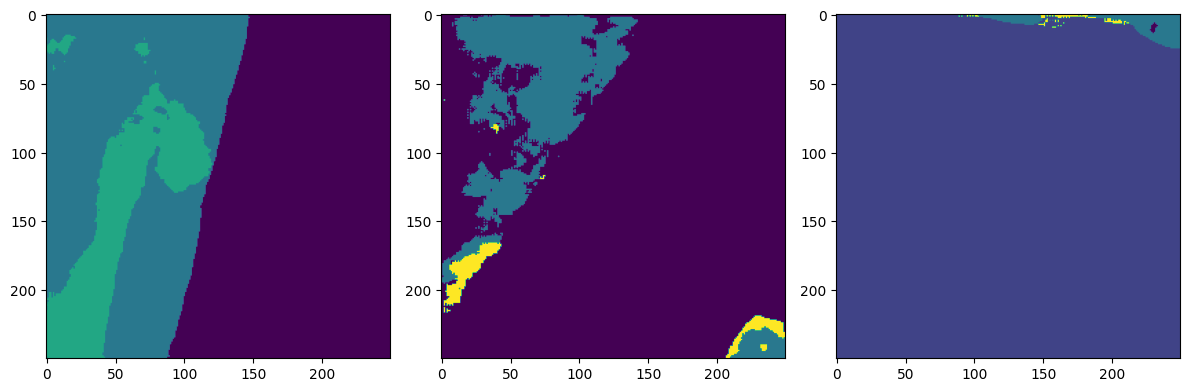

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

class_mapping = {
    0: (255, 255, 255),  # Impervious surfaces
    1: (0, 0, 255),      # Building
    2: (0, 255, 255),    # Low vegetation
    3: (0, 255, 0),      # Tree
    4: (255, 255, 0),    # Car
    5: (255, 0, 0)       # Clutter/background
}

# Assumi che 'model' sia il tuo modello addestrato e 'test_loader' sia il dataloader per il test set

def plot_segmented_images(images, predicted_labels, classes_name, num_examples=5):
    plt.figure(figsize=(12, 18))
    unnormalize = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                                     transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        image = unnormalize(images[i].cpu()).permute(1, 2, 0)  # Unnormalize and convert to (H, W, C)
        predicted_label = predicted_labels[i].cpu().numpy()
        predicted_mask = np.zeros(image.shape[:2], dtype=np.uint8)

        for label_id, rgb_color in class_mapping.items():
            mask = predicted_label == label_id
            predicted_mask[mask] = label_id

        plt.imshow(predicted_mask, vmin=0, vmax=len(classes_name) - 1)
       # plt.title(f"Predicted: {classes_name[predicted_label]}")
        plt.axis('on')

    plt.tight_layout()
    plt.show()

# Prendi alcuni esempi dal dataloader di test
num_examples = 3
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx >= num_examples:
            break
        data = data.to(device)

        # Calcola le predizioni
        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)
        predicted_labels = torch.argmax(output, axis=1)

        # Stampa le immagini segmentate predette
        plot_segmented_images(data, predicted_labels, list(class_mapping.values()), num_examples)


ValueError: ignored

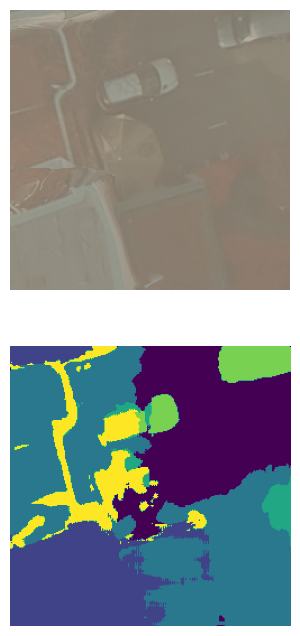

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

class_mapping = {
    0: (255, 255, 255),  # Impervious surfaces
    1: (0, 0, 255),      # Building
    2: (0, 255, 255),    # Low vegetation
    3: (0, 255, 0),      # Tree
    4: (255, 255, 0),    # Car
    5: (255, 0, 0)       # Clutter/background
}

# Assumi che 'model' sia il tuo modello addestrato e 'test_loader' sia il dataloader per il test set

def plot_segmented_images(images, predicted_labels, classes_name, num_examples=5):
    plt.figure(figsize=(10, 8))
    unnormalize = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                                     transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

    for i in range(num_examples):
        plt.subplot(3, num_examples, i + 1)
        original_image = unnormalize(images[i].cpu()).permute(1, 2, 0)  # Unnormalize and convert to (H, W, C)
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(3, num_examples, i + 1 + num_examples)
        predicted_label = predicted_labels[i].cpu().numpy()
        predicted_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

        for label_id, rgb_color in class_mapping.items():
            mask = predicted_label == label_id
            predicted_mask[mask] = label_id

        plt.imshow(predicted_mask, vmin=0, vmax=len(classes_name) - 1, cmap='viridis')
        plt.axis('off')

        plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
        plt.imshow(original_image)
        plt.imshow(predicted_mask, alpha=0.5, cmap='jet', vmin=0, vmax=len(classes_name) - 1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prendi alcuni esempi dal dataloader di test
num_examples = 2
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx >= num_examples:
            break
        data = data.to(device)

        # Calcola le predizioni
        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)
        predicted_labels = torch.argmax(output, axis=1)

        # Stampa le immagini segmentate predette
        plot_segmented_images(data, predicted_labels, list(class_mapping.values()), num_examples)


In [ ]:
import torch

# Ottieni un batch dal train_loader (in questo esempio prendiamo il primo batch)
batch = next(iter(train_loader))

# Estrai le immagini delle etichette (labels) dal batch
labels = batch[1]  # Assumendo che le etichette siano nel secondo elemento del batch

# Scegli un'immagine dalle etichette (in questo esempio prendiamo la prima immagine)
label_image = labels[0]

# Scorrere attraverso ciascun pixel dell'immagine delle etichette e stamparne i valori
for row in labels:
    for pixel_value in row:
        print(pixel_value.long())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)

In [ ]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.nn as nn
from torch import optim
#from tensorboardX import SummaryWriter


def train_epoch(epoch,train_loader,criterion,optimizer,batch_size,scheduler):

    net.train()
    epoch_loss = 0

    for i, (data, target) in enumerate(train_loader):

        imgs = data
        true_masks = target

        imgs = imgs.to(device)
        true_masks = true_masks.to(device)

        outputs = net(imgs)
        probs = torch.softmax(outputs, dim=1)
        masks_pred = torch.argmax(probs, dim=1)

        loss = criterion(outputs, true_masks)
        epoch_loss += loss.item()

        print(f'epoch = {epoch+1:d}, iteration = {i:d}/{len(train_loader):d}, loss = {loss.item():.5f}')
        # save to summary
        #if i%100==0:
            #writer.add_scalar('train_loss_iter',
            #                      loss.item(),
            #                      i + len(train_loader) * epoch)
            #writer.add_figure('predictions vs. actuals',
            #                      plot_net_predictions(imgs, true_masks, masks_pred, batch_size),
            #                      global_step = i + len(train_loader) * epoch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch finished ! Loss: {epoch_loss/i:.2f}, lr:{scheduler.get_lr()}')


def validate_epoch(epoch,train_loader,val_loader,device):

    class_iou, mean_iou = eval_net_loader(net, val_loader, 3, device)
    print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')
    # save to summary
    #writer.add_scalar('mean_iou', mean_iou, len(train_loader) * (epoch+1))

    return mean_iou


def train_net(train_loader, val_loader, net, device, epochs=5, batch_size=1, lr=0.1, save_cp=True):

#     params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4}
#     train_loader, val_loader =  make_dataloaders(dir_data, val_ratio, params)

    print(f'''
    Starting training:
        Epochs: {epochs}
        Batch size: {batch_size}
        Learning rate: {lr}
        Training size: {len(train_loader.dataset)}
        Validation size: {len(val_loader.dataset)}
        Checkpoints: {str(save_cp)}
        Device: {str(device)}
    ''')

    optimizer = optim.SGD(net. parameters(),lr=lr, momentum=0.9, weight_decay=0.0005)
    # multiply learning rate by 0.1 after 30% of epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(0.3*epochs), gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    # weighted cross entropy loss
#     criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 8.2, 1.0]).cuda())

    best_precision = 0
    for epoch in range(epochs):

        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        train_epoch(epoch,train_loader,criterion,optimizer,batch_size,scheduler)
        precision = validate_epoch(epoch,train_loader,val_loader,device)
        scheduler.step()

        if save_cp and (precision>best_precision):
            state_dict = net.state_dict()
            if device=="cuda":
                state_dict = net.module.state_dict()
            torch.save(state_dict, dir_checkpoint+f'CP{epoch + 1}.pth')
            print('Checkpoint {} saved !'.format(epoch + 1))
            best_precision = precision

    #writer.close()


def get_args():

    parser = OptionParser()
    parser.add_option('-e', '--epochs', dest='epochs', default=5, type='int',
                      help='number of epochs')
    parser.add_option('-b', '--batch-size', dest='batchsize', default=8,
                      type='int', help='batch size')
    parser.add_option('-l', '--learning-rate', dest='lr', default=0.1,
                      type='float', help='learning rate')
    parser.add_option('-c', '--load', dest='load',
                      default=False, help='load file model')
    parser.add_option('-f', '--folder', dest='folder',
                      default='', help='folder name')

    (options, args) = parser.parse_args()
    return options


if __name__ == '__main__':

    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    args = get_args()

    dir_data = f'./data/{args.folder}'
    dir_checkpoint = f'./checkpoints/{args.folder}_b{args.batchsize}/'
    dir_summary = f'./runs/{args.folder}_b{args.batchsize}'
    params = {'batch_size': args.batchsize, 'shuffle': True, 'num_workers': 4}

    #make_checkpoint_dir(dir_checkpoint)
    #writer = SummaryWriter(dir_summary)

    val_ratio=0.1
    #train_loader, val_loader =  make_dataloaders(dir_data, val_ratio, params)

    net = UNet(n_channels=3, n_classes=6)
    net.to(device)

    if args.load:
        net.load_state_dict(torch.load(args.load))
        print('Model loaded from {}'.format(args.load))

    # train model in parallel on multiple-GPUs
    if torch.cuda.device_count() > 1:
        print("Model training on", torch.cuda.device_count(), "GPUs")
        net = nn.DataParallel(net)

    try:
        train_net(train_loader, val_loader, net, device, epochs=args.epochs, batch_size=args.batchsize, lr=args.lr)

    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        print('Saved interrupt')
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)


    Starting training:
        Epochs: 5
        Batch size: 8
        Learning rate: 0.1
        Training size: 17512
        Validation size: 2188
        Checkpoints: True
        Device: cpu
    
Starting epoch 1/5.


RuntimeError: ignored